In [30]:
import pandas as pd
import openpyxl
import numpy as np
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import os
import sys

In [32]:
sys.path.append(os.path.join(os.getcwd(), 'Helper'))
import pmp_functions_v4 as pmp

In [22]:
data_path = '../Data/'

In [ ]:
# --- 1. DEFINE THE MISSING HELPER FUNCTION ---
def process_bloomberg_sheet(df, remove_header_rows=0):
    """
    Standard cleaning for Excel exports.
    1. Removes top N metadata rows.
    2. Finds the header row containing 'Date'.
    3. Resets index.
    """
    df = df.iloc[remove_header_rows:].copy()
    
    # Simple clean: Ensure we don't have empty rows at the top
    df = df.dropna(how='all')
    
    # If the first column isn't "Date", try to find the header
    # (This is a failsafe if headers are on row 3, for example)
    if "Date" not in df.columns:
        # Try to find the row that contains "Date"
        for i in range(min(10, len(df))):
            row_vals = df.iloc[i].astype(str).values
            if "Date" in row_vals:
                df.columns = df.iloc[i]
                df = df.iloc[i+1:]
                break
    
    return df


Processing sheets...
Success. Joined 7 assets.
Final Data Shape: (551, 7)
Generating signals...
Running Strategy...
Realized Volatility (Unscaled): 11.45%
Applying Scaling Factor: 0.87


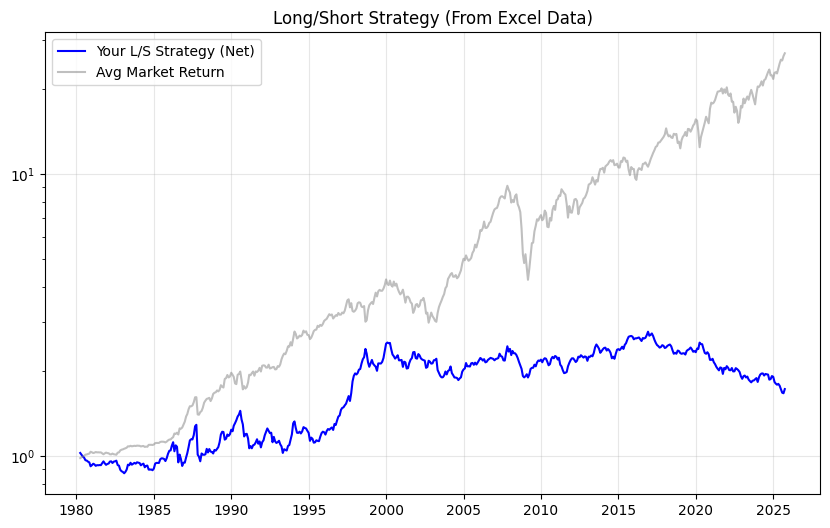

                         My Strategy
Arithm Avg Total Return       1.7150
Arithm Avg Xs Return         -0.2850
Std Xs Returns                9.9999
Sharpe Arithmetic            -0.0285
Geom Avg Total Return         1.2127
Geom Avg Xs Return           -0.8057
Sharpe Geometric             -0.0806
Min Xs Return               -21.7805
Max Xs Return                 9.8946
Skewness                     -0.8946
Excess Kurtosis               6.3452
Alpha Arithmetic             -0.7204
Alpha Arithmetic p-val        0.6618
Alpha Geometric              -1.2458
Beta 1                        0.0718
Beta 1 p-val                  0.2199
Tracking Error                9.9668
Information Ratio            -0.1250
AC 1                          0.0960
AC 2                          0.0309
AC 3                          0.0039
Realized Volatility (Scaled): 10.00%


In [40]:

VOL_TARGET = 0.10

# --- 2. YOUR DATA LOADING LOGIC (As Provided) ---
# Make sure 'Prices.xlsx' is in your path
raw_sheets = pd.read_excel(os.path.join(data_path, 'Prices.xlsx'), sheet_name=None)
processed_frames = []

print("Processing sheets...")
for sheet_name, df_raw in raw_sheets.items():
    # 1. Clean the specific sheet
    clean_df = process_bloomberg_sheet(df_raw, remove_header_rows=0)
    
    if clean_df is not None and not clean_df.empty:
        # 2. Generate identifier
        safe_name = re.sub(r'\W|^(?=\d)', '_', sheet_name)
        
        # 3. Rename columns to include the asset name.
        clean_df.columns = [f"{safe_name}_{col}" for col in clean_df.columns]
        
        # 4. Handle Date Index
        # Find the column that contains "Date" (case insensitive check)
        date_cols = [c for c in clean_df.columns if "date" in str(c).lower()]
        
        if date_cols:
            target_date_col = date_cols[0]
            clean_df = clean_df.set_index(target_date_col)
            # Ensure index is datetime
            clean_df.index = pd.to_datetime(clean_df.index, errors='coerce')
            processed_frames.append(clean_df)
        else:
            print(f"Skipping {sheet_name}: No 'Date' column found.")

# --- JOIN OPERATION ---
if processed_frames:
    equity_market_return = pd.concat(processed_frames, axis=1, sort=True)
    
    # Filter for (USD) columns as requested
    # CRITICAL: Assuming your columns look like 'Asset_PX_LAST(USD)'
    columns = [x for x in equity_market_return.columns if x.endswith('(USD)')]
    
    if len(columns) == 0:
        print("WARNING: No columns found ending in '(USD)'. Check your Excel headers.")
        print("Available columns:", equity_market_return.columns[:5])
        # Fallback: Use all numeric columns if filter fails
        df_prices = equity_market_return.select_dtypes(include=[np.number])
    else:
        equity_market_return = equity_market_return[columns]
        df_prices = equity_market_return.copy()

    print(f"Success. Joined {len(processed_frames)} assets.")
    print(f"Final Data Shape: {df_prices.shape}")
else:
    raise ValueError("No valid dataframes processed.")

# --- 3. PREPARE FOR STRATEGY (Resampling) ---
# Ensure numeric
df_prices = df_prices.apply(pd.to_numeric, errors='coerce')

# Resample to Month End (Strategy Requirement)
df_prices = df_prices.resample("ME").last().ffill()

# Calculate Returns
returns = df_prices.pct_change().fillna(0)
rf_series = pd.Series(0.02/12, index=returns.index, name="RF")

# --- 4. SIGNAL GENERATION ---
lookbacks = [1, 3, 12]
vol_lookback = 36
raw_signal = pd.DataFrame(0.0, index=df_prices.index, columns=df_prices.columns)

print("Generating signals...")
for lag in lookbacks:
    mom = df_prices.pct_change(lag)
    vol = returns.rolling(vol_lookback).std()
    sig = mom.div(vol).replace([np.inf, -np.inf], 0).fillna(0)
    raw_signal += sig

final_signal = raw_signal / len(lookbacks)

# --- 5. EXECUTE LONG/SHORT STRATEGY ---
print("Running Strategy...")

# Dummy benchmark for function signature
dummy_bm = returns.mean(axis=1) 

weights_unscaled = pmp.make_country_weights(
    signal=final_signal,
    returns=returns,
    benchmark_series=dummy_bm,
    k=3,                   # Long Top 3 / Short Bottom 3
    long_short=True,
    beta_neutral=False,    # Dollar Neutral
    signal_lag=1,
    min_regions=4          # Min assets required to trade
)

res_unscaled = pmp.run_cc_strategy(
    weights=weights_unscaled,
    returns=returns,
    rf=rf_series,
    frequency=1,
    t_cost=0.0010,         # 10bps cost
    benchmark="equal", 
    long_short=True,
    beta_neutral=False
)

unscaled_returns = res_unscaled["ret_net"].dropna()
if not unscaled_returns.empty:
# Calculate realized annualized volatility (Standard Deviation * sqrt(12))
    realized_vol = unscaled_returns.std() * np.sqrt(12)
    
    # Calculate the required scaling factor (Lambda)
    # Scale = Target Vol / Realized Vol
    scaling_factor = VOL_TARGET / realized_vol
    
    # Critical: Cap the scaling factor to prevent excessive leverage
    max_leverage = 2.0 # Cap at 200% gross leverage, adjust as needed
    scaling_factor = min(scaling_factor, max_leverage) 
    
    print(f"Realized Volatility (Unscaled): {realized_vol:.2%}")
    print(f"Applying Scaling Factor: {scaling_factor:.2f}")

    # 3. Apply Scaling to Weights
    # Scale every position by the calculated factor
    weights_scaled = weights_unscaled * scaling_factor
else:
    print("WARNING: Cannot calculate volatility, defaulting to unscaled weights.")
    weights_scaled = weights_unscaled

res = pmp.run_cc_strategy(
    weights=weights_scaled, # <--- Using the scaled weights
    returns=returns,
    rf=rf_series,
    frequency=1,
    t_cost=0.0010,         
    benchmark="equal", 
    long_short=True,
    beta_neutral=False
)

# --- 6. OUTPUT ---
cum_strat = (1 + res["ret_net"]).cumprod()
cum_bm = (1 + res["ret_bm"]).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cum_strat, label="Your L/S Strategy (Net)", color="blue")
plt.plot(cum_bm, label="Avg Market Return", color="gray", alpha=0.5)
plt.title("Long/Short Strategy (From Excel Data)")
plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Stats
xs_strat = res["ret_net"] - res["ret_rf"]
xs_bm = res["ret_bm"] - res["ret_rf"]

summary = pmp.summarizePerformance(
    xsReturns=xs_strat.values.reshape(-1, 1),
    Rf=res["ret_rf"].values.reshape(-1, 1),
    factorXsReturns=xs_bm.values.reshape(-1, 1),
    annualizationFactor=12,
    strategyNames=["My Strategy"]
)
print(summary)

scaled_returns = res["ret_net"].dropna()
if not scaled_returns.empty:
# Calculate realized annualized volatility (Standard Deviation * sqrt(12))
    realized_vol = scaled_returns.std() * np.sqrt(12)
    print(f"Realized Volatility (Scaled): {realized_vol:.2%}")